In [6]:
import warnings
warnings.filterwarnings("ignore") 

In [12]:
print(df_rule_based.columns)


Index(['Cell Number', 'Cell Type', 'X Centroid', 'Y Centroid',
       'Clustering Label'],
      dtype='object')



✅ Labels for Rule-Based and Clustering saved in 'rule_vs_clustering_labels.csv'


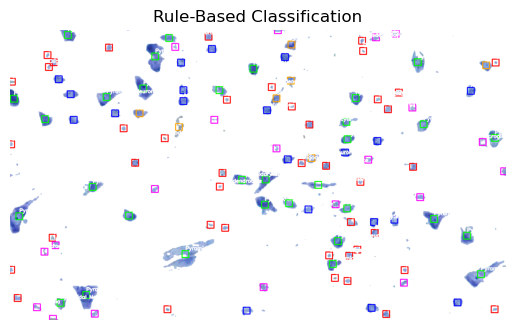

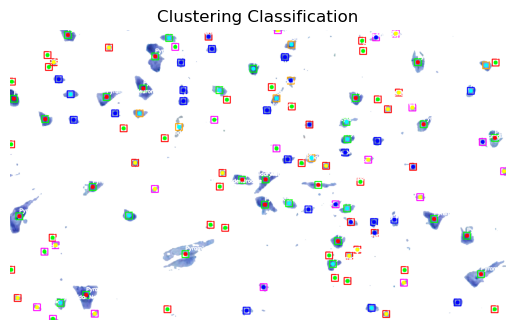

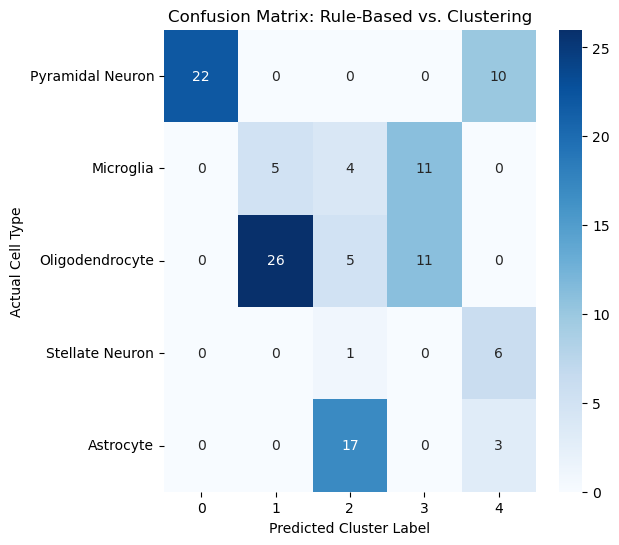

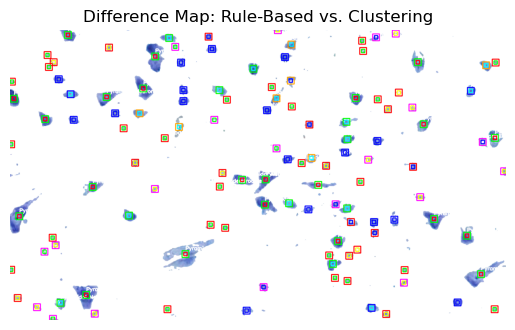


✅ Chi-Square Test: p=4.456495388326468e-35
✅ KS Test: p=0.3941132591604492
✅ Mann-Whitney U Test: p=0.29318453635523334
✅ Cohen's Kappa: 0.10670443814919739


In [34]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import warnings
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, confusion_matrix, cohen_kappa_score
from scipy.stats import chi2_contingency, ks_2samp, mannwhitneyu
from sklearn.decomposition import PCA
import umap
from PIL import Image

# Ignore warnings
warnings.filterwarnings("ignore")

# ------------------- Load Data -------------------

df_features = pd.read_csv("data_cell_for_clustering.csv")  
df_centroids = pd.read_csv(r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\data_cell_with_centroids.csv")

# Load rule-based classification results
df_rule_based = df_centroids[['Cell Number', 'Cell Type', 'X Centroid', 'Y Centroid']]

# Assign feature weights
feature_weights = {"Solidity": 3, "Circularity": 3, "Local_Homogeneity": 3, "Aspect Ratio": 3}

# Apply weights to selected features
df_weighted = df_features.copy()
for col, weight in feature_weights.items():
    if col in df_weighted.columns:
        df_weighted[col] *= weight

# Extract feature matrix
features = df_weighted.iloc[:, 1:].values.astype(np.float32)
dim_features = features.shape[1]

# Convert to PyTorch tensor
features_tensor = torch.from_numpy(features)

# ------------------- Contrastive Clustering Model -------------------
class ContrastiveClustering(nn.Module):
    def __init__(self, input_dim, embedding_dim=128):
        super(ContrastiveClustering, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, embedding_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Initialize model
embedding_dim = 128
model = ContrastiveClustering(input_dim=dim_features, embedding_dim=embedding_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()
    reconstructed = model(features_tensor)
    loss = criterion(reconstructed, features_tensor)
    loss.backward()
    optimizer.step()

# Extract learned embeddings
with torch.no_grad():
    embeddings = model.encoder(features_tensor).numpy()

# UMAP for Dimensionality Reduction
umap_model = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
umap_embeddings = umap_model.fit_transform(embeddings)

# K-Means Clustering (n=5)
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
df_rule_based["Clustering Label"] = kmeans.fit_predict(umap_embeddings)

# Save labels
df_rule_based.to_csv("rule_vs_clustering_labels.csv", index=False)
print("\n✅ Labels for Rule-Based and Clustering saved in 'rule_vs_clustering_labels.csv'")

# ------------------- Define Colors -------------------

rule_based_colors = {
    "Astrocyte": (0, 0, 255),  # Red
    "Oligodendrocyte": (255, 0, 0),  # Blue
    "Microglia": (255, 0, 255),  # Purple
    "Pyramidal Neuron": (0, 255, 0),  # Green
    "Stellate Neuron": (255, 165, 0)  # Orange
}

cluster_colors = {
    0: (255, 0, 0),  # Blue
    1: (0, 255, 0),  # Green
    2: (0, 0, 255),  # Red
    3: (255, 255, 0),  # Yellow
    4: (0, 255, 255)  # Cyan
}

# ------------------- Rule-Based Classification Image -------------------
image = cv2.imread( "restored_white_background_debug-Copy1.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

for _, row in df_rule_based.iterrows():
    x, y = int(row["X Centroid"]), int(row["Y Centroid"])
    cell_type = row["Cell Type"]
    
    cv2.rectangle(image, (x - 10, y - 10), (x + 10, y + 10), rule_based_colors.get(cell_type, (255, 255, 255)), 2)
    cv2.putText(image, cell_type, (x, y - 12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

plt.imshow(image)
plt.title("Rule-Based Classification")
plt.axis("off")
plt.show()
cv2.imwrite("rule_based_labeled.png", cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

# ------------------- Clustering Classification Image -------------------
image_clustering = image.copy()
for _, row in df_rule_based.iterrows():
    x, y = int(row["X Centroid"]), int(row["Y Centroid"])
    cluster_label = row["Clustering Label"]
    
    cv2.circle(image_clustering, (x, y), 6, cluster_colors.get(cluster_label, (255, 255, 255)), -1)

plt.imshow(image_clustering)
plt.title("Clustering Classification")
plt.axis("off")
plt.show()
cv2.imwrite("clustering_labeled.png", cv2.cvtColor(image_clustering, cv2.COLOR_RGB2BGR))

# ------------------- Generate Confusion Matrix -------------------
plt.figure(figsize=(6, 6))
conf_matrix = confusion_matrix(df_rule_based["Cell Type"].factorize()[0], df_rule_based["Clustering Label"])

# Plot confusion matrix as a heatmap
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(df_rule_based["Clustering Label"]),
            yticklabels=df_rule_based["Cell Type"].unique())

plt.xlabel("Predicted Cluster Label")
plt.ylabel("Actual Cell Type")
plt.title("Confusion Matrix: Rule-Based vs. Clustering")

# Save and show the plot
plt.savefig("confusion_matrix.png", dpi=300)
plt.show()


# ------------------- Difference Map -------------------
image_difference = image.copy()
for _, row in df_rule_based.iterrows():
    x, y = int(row["X Centroid"]), int(row["Y Centroid"])
    cell_type = row["Cell Type"]
    cluster_label = row["Clustering Label"]
    
    cv2.rectangle(image_difference, (x - 10, y - 10), (x + 10, y + 10), rule_based_colors.get(cell_type, (255, 255, 255)), 2)
    cv2.rectangle(image_difference, (x - 5, y - 5), (x + 5, y + 5), cluster_colors.get(cluster_label, (255, 255, 255)), 2)

plt.imshow(image_difference)
plt.title("Difference Map: Rule-Based vs. Clustering")
plt.axis("off")
plt.show()
cv2.imwrite("difference_map.png", cv2.cvtColor(image_difference, cv2.COLOR_RGB2BGR))

# ------------------- Statistical Tests -------------------
chi2, p, _, _ = chi2_contingency(pd.crosstab(df_rule_based["Cell Type"], df_rule_based["Clustering Label"]))
ks_stat, ks_p = ks_2samp(df_rule_based["Cell Type"].factorize()[0], df_rule_based["Clustering Label"])
mw_stat, mw_p = mannwhitneyu(df_rule_based["Cell Type"].factorize()[0], df_rule_based["Clustering Label"])
cohen_kappa = cohen_kappa_score(df_rule_based["Cell Type"].factorize()[0], df_rule_based["Clustering Label"])

print(f"\n✅ Chi-Square Test: p={p}")
print(f"✅ KS Test: p={ks_p}")
print(f"✅ Mann-Whitney U Test: p={mw_p}")
print(f"✅ Cohen's Kappa: {cohen_kappa}")


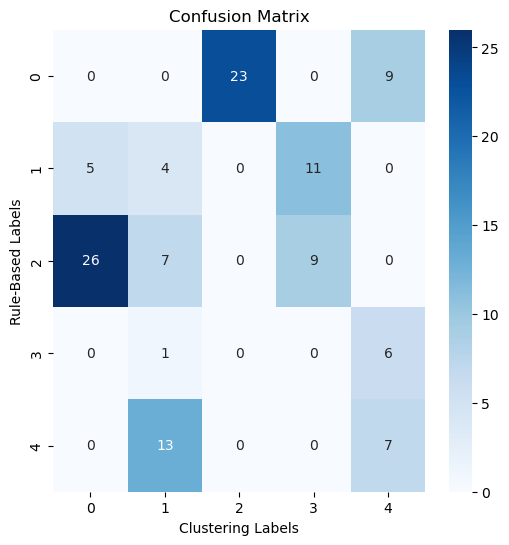

Chi-Square Test: χ² = 188.732, p = 0.00000
Kolmogorov-Smirnov Test: D = 0.124, p = 0.31129
Mann-Whitney U Test: U = 7024.000, p = 0.57701
Cohen’s Kappa Score: κ = -0.147


In [36]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import warnings
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from scipy.stats import chi2_contingency, ks_2samp, mannwhitneyu
import umap

# Ignore warnings
warnings.filterwarnings("ignore")

# ------------------- Load Data -------------------
df_features = pd.read_csv("data_cell_for_clustering.csv")  
df_centroids = pd.read_csv(r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\data_cell_with_centroids.csv")

df_rule_based = df_centroids[['Cell Number', 'Cell Type', 'X Centroid', 'Y Centroid']]

# Assign feature weights
feature_weights = {"Solidity": 3, "Circularity": 3, "Local_Homogeneity": 3, "Aspect Ratio": 3}

df_weighted = df_features.copy()
for col, weight in feature_weights.items():
    if col in df_weighted.columns:
        df_weighted[col] *= weight

# Extract feature matrix
features = df_weighted.iloc[:, 1:].values.astype(np.float32)
dim_features = features.shape[1]

features_tensor = torch.from_numpy(features)

# ------------------- Contrastive Clustering Model -------------------
class ContrastiveClustering(nn.Module):
    def __init__(self, input_dim, embedding_dim=128):
        super(ContrastiveClustering, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, embedding_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Initialize model
embedding_dim = 128
model = ContrastiveClustering(input_dim=dim_features, embedding_dim=embedding_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()
    reconstructed = model(features_tensor)
    loss = criterion(reconstructed, features_tensor)
    loss.backward()
    optimizer.step()

# Extract learned embeddings
with torch.no_grad():
    embeddings = model.encoder(features_tensor).numpy()

# UMAP for Dimensionality Reduction
umap_model = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
umap_embeddings = umap_model.fit_transform(embeddings)

# K-Means Clustering (n=5 for exactly five clusters)
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
df_rule_based["Clustering Label"] = kmeans.fit_predict(umap_embeddings)

df_rule_based.to_csv("rule_vs_clustering_labels.csv", index=False)

# ------------------- Load Image -------------------
image_path =  "restored_white_background_debug-Copy1.png"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Define colors
rule_based_colors = {
    "Astrocyte": (0, 0, 255),  # Red
    "Oligodendrocyte": (255, 0, 0),  # Blue
    "Microglia": (255, 0, 255),  # Purple
    "Pyramidal Neuron": (0, 255, 0),  # Green
    "Stellate Cell": (255, 165, 0)  # Orange
}

cluster_colors = {
    0: (255, 0, 0),  # Blue
    1: (0, 255, 0),  # Green
    2: (0, 0, 255),  # Red
    3: (255, 255, 0),  # Yellow
    4: (255, 165, 0)  # Orange (for merged Stellate Cells)
}

# ------------------- Rule-Based Image -------------------
rule_based_image = image.copy()
for _, row in df_rule_based.iterrows():
    x, y = int(row["X Centroid"]), int(row["Y Centroid"])
    cell_type = row["Cell Type"]
    cv2.rectangle(rule_based_image, (x - 10, y - 10), (x + 10, y + 10), rule_based_colors.get(cell_type, (255, 255, 255)), 2)

cv2.imwrite("rule_based_labeled.png", cv2.cvtColor(rule_based_image, cv2.COLOR_RGB2BGR))

# ------------------- Clustering Image -------------------
clustering_image = image.copy()
for _, row in df_rule_based.iterrows():
    x, y = int(row["X Centroid"]), int(row["Y Centroid"])
    cluster_label = row["Clustering Label"]
    cv2.circle(clustering_image, (x, y), 6, cluster_colors.get(cluster_label, (255, 255, 255)), -1)

cv2.imwrite("clustering_labeled.png", cv2.cvtColor(clustering_image, cv2.COLOR_RGB2BGR))

# ------------------- Difference Map -------------------
diff_map = image.copy()
for _, row in df_rule_based.iterrows():
    x, y = int(row["X Centroid"]), int(row["Y Centroid"])
    cell_type = row["Cell Type"]
    cluster_label = row["Clustering Label"]

    # Rule-based bounding box
    cv2.rectangle(diff_map, (x - 10, y - 10), (x + 10, y + 10), rule_based_colors.get(cell_type, (255, 255, 255)), 2)

    # Clustering shaded circle
    cv2.circle(diff_map, (x, y), 6, cluster_colors.get(cluster_label, (255, 255, 255)), -1)

cv2.imwrite("difference_map.png", cv2.cvtColor(diff_map, cv2.COLOR_RGB2BGR))

# ------------------- Confusion Matrix -------------------
plt.figure(figsize=(6, 6))
conf_matrix = confusion_matrix(df_rule_based["Cell Type"].factorize()[0], df_rule_based["Clustering Label"])
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Clustering Labels")
plt.ylabel("Rule-Based Labels")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")
plt.show()

# ------------------- Statistical Tests -------------------
chi2, p, _, _ = chi2_contingency(conf_matrix)
ks_stat, ks_pval = ks_2samp(df_rule_based["Cell Type"].factorize()[0], df_rule_based["Clustering Label"])
mw_stat, mw_pval = mannwhitneyu(df_rule_based["Cell Type"].factorize()[0], df_rule_based["Clustering Label"])
kappa = cohen_kappa_score(df_rule_based["Cell Type"].factorize()[0], df_rule_based["Clustering Label"])

print(f"Chi-Square Test: χ² = {chi2:.3f}, p = {p:.5f}")
print(f"Kolmogorov-Smirnov Test: D = {ks_stat:.3f}, p = {ks_pval:.5f}")
print(f"Mann-Whitney U Test: U = {mw_stat:.3f}, p = {mw_pval:.5f}")
print(f"Cohen’s Kappa Score: κ = {kappa:.3f}")


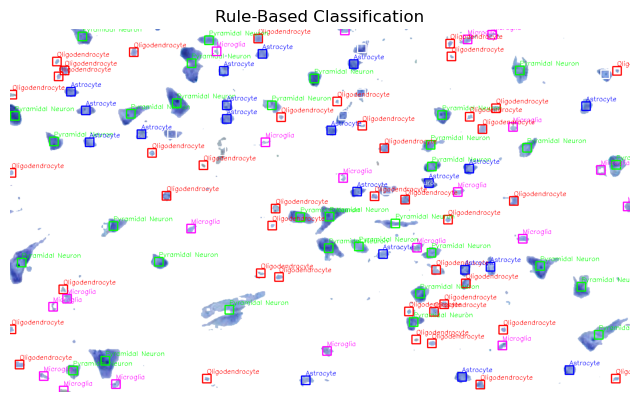

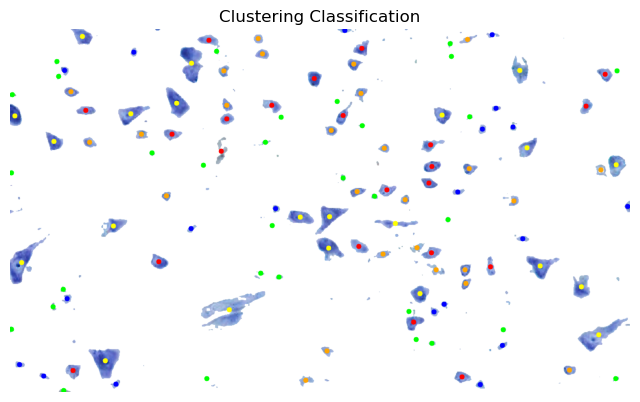

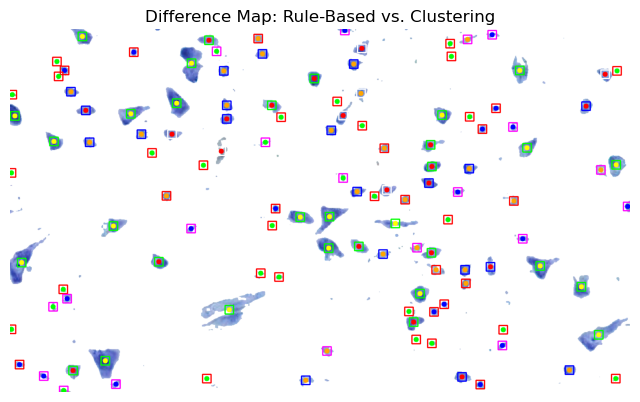

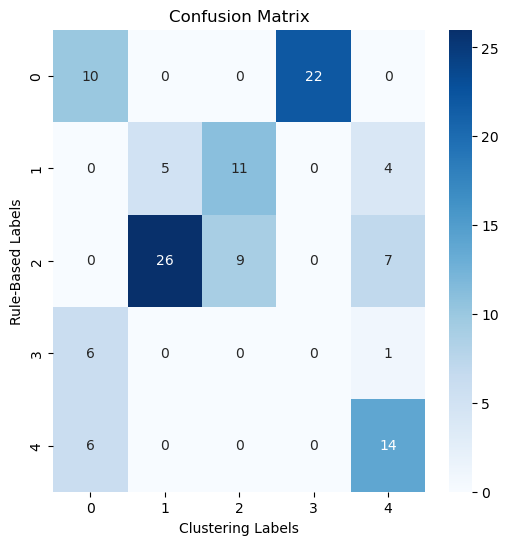

Chi-Square Test: χ² = 188.959, p = 0.00000
Kolmogorov-Smirnov Test: D = 0.174, p = 0.05209
Mann-Whitney U Test: U = 6496.000, p = 0.12132
Cohen’s Kappa Score: κ = 0.149


In [40]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import warnings
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from scipy.stats import chi2_contingency, ks_2samp, mannwhitneyu
import umap

# Ignore warnings
warnings.filterwarnings("ignore")

# ------------------- Load Data -------------------
df_features = pd.read_csv("data_cell_for_clustering.csv")  
df_centroids = pd.read_csv(r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\data_cell_with_centroids.csv")

df_rule_based = df_centroids[['Cell Number', 'Cell Type', 'X Centroid', 'Y Centroid']]

# Assign feature weights
feature_weights = {"Solidity": 3, "Circularity": 3, "Local_Homogeneity": 3, "Aspect Ratio": 3}

df_weighted = df_features.copy()
for col, weight in feature_weights.items():
    if col in df_weighted.columns:
        df_weighted[col] *= weight

# Extract feature matrix
features = df_weighted.iloc[:, 1:].values.astype(np.float32)
dim_features = features.shape[1]

features_tensor = torch.from_numpy(features)

# ------------------- Contrastive Clustering Model -------------------
class ContrastiveClustering(nn.Module):
    def __init__(self, input_dim, embedding_dim=128):
        super(ContrastiveClustering, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, embedding_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Initialize model
embedding_dim = 128
model = ContrastiveClustering(input_dim=dim_features, embedding_dim=embedding_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()
    reconstructed = model(features_tensor)
    loss = criterion(reconstructed, features_tensor)
    loss.backward()
    optimizer.step()

# Extract learned embeddings
with torch.no_grad():
    embeddings = model.encoder(features_tensor).numpy()

# UMAP for Dimensionality Reduction
umap_model = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
umap_embeddings = umap_model.fit_transform(embeddings)

# K-Means Clustering (n=5)
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
df_rule_based["Clustering Label"] = kmeans.fit_predict(umap_embeddings)

df_rule_based.to_csv("rule_vs_clustering_labels.csv", index=False)

# ------------------- Load Image -------------------
image_path = "restored_white_background_debug-Copy1.png"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Define colors
rule_based_colors = {
    "Astrocyte": (0, 0, 255),  # Red
    "Oligodendrocyte": (255, 0, 0),  # Blue
    "Microglia": (255, 0, 255),  # Purple
    "Pyramidal Neuron": (0, 255, 0),  # Green
    "Stellate Cell": (255, 165, 0)  # Orange
}

cluster_colors = {
    0: (255, 0, 0),  # Blue
    1: (0, 255, 0),  # Green
    2: (0, 0, 255),  # Red
    3: (255, 255, 0),  # Yellow
    4: (255, 165, 0)  # Orange
}

# ------------------- Generate & Display 3 Images -------------------

def save_and_show(image, filename, title):
    """Saves the image and displays it."""
    cv2.imwrite(filename, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    plt.figure(figsize=(8,8))
    plt.imshow(image)
    plt.title(title)
    plt.axis("off")
    plt.show()

# **1️⃣ Rule-Based Image (Bounding Boxes & Labels)**
rule_based_image = image.copy()
for _, row in df_rule_based.iterrows():
    x, y = int(row["X Centroid"]), int(row["Y Centroid"])
    cell_type = row["Cell Type"]
    color = rule_based_colors.get(cell_type, (255, 255, 255))
    cv2.rectangle(rule_based_image, (x - 10, y - 10), (x + 10, y + 10), color, 2)
    cv2.putText(rule_based_image, cell_type, (x, y - 12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

save_and_show(rule_based_image, "rule_based_labeled.png", "Rule-Based Classification")

# **2️⃣ Clustering Image (Shaded Circles)**
clustering_image = image.copy()
for _, row in df_rule_based.iterrows():
    x, y = int(row["X Centroid"]), int(row["Y Centroid"])
    cluster_label = row["Clustering Label"]
    cv2.circle(clustering_image, (x, y), 6, cluster_colors.get(cluster_label, (255, 255, 255)), -1)

save_and_show(clustering_image, "clustering_labeled.png", "Clustering Classification")

# **3️⃣ Difference Map (Bounding Boxes + Circles)**
diff_map = image.copy()
for _, row in df_rule_based.iterrows():
    x, y = int(row["X Centroid"]), int(row["Y Centroid"])
    cell_type = row["Cell Type"]
    cluster_label = row["Clustering Label"]

    # Rule-based bounding box
    cv2.rectangle(diff_map, (x - 10, y - 10), (x + 10, y + 10), rule_based_colors.get(cell_type, (255, 255, 255)), 2)

    # Clustering shaded circle
    cv2.circle(diff_map, (x, y), 6, cluster_colors.get(cluster_label, (255, 255, 255)), -1)

save_and_show(diff_map, "difference_map.png", "Difference Map: Rule-Based vs. Clustering")

# ------------------- Confusion Matrix -------------------
plt.figure(figsize=(6, 6))
conf_matrix = confusion_matrix(df_rule_based["Cell Type"].factorize()[0], df_rule_based["Clustering Label"])
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Clustering Labels")
plt.ylabel("Rule-Based Labels")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")
plt.show()

# ------------------- Statistical Tests -------------------
chi2, p, _, _ = chi2_contingency(conf_matrix)
ks_stat, ks_pval = ks_2samp(df_rule_based["Cell Type"].factorize()[0], df_rule_based["Clustering Label"])
mw_stat, mw_pval = mannwhitneyu(df_rule_based["Cell Type"].factorize()[0], df_rule_based["Clustering Label"])
kappa = cohen_kappa_score(df_rule_based["Cell Type"].factorize()[0], df_rule_based["Clustering Label"])

print(f"Chi-Square Test: χ² = {chi2:.3f}, p = {p:.5f}")
print(f"Kolmogorov-Smirnov Test: D = {ks_stat:.3f}, p = {ks_pval:.5f}")
print(f"Mann-Whitney U Test: U = {mw_stat:.3f}, p = {mw_pval:.5f}")
print(f"Cohen’s Kappa Score: κ = {kappa:.3f}")


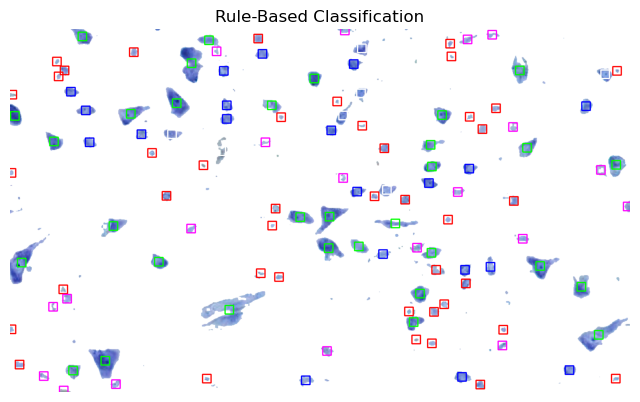

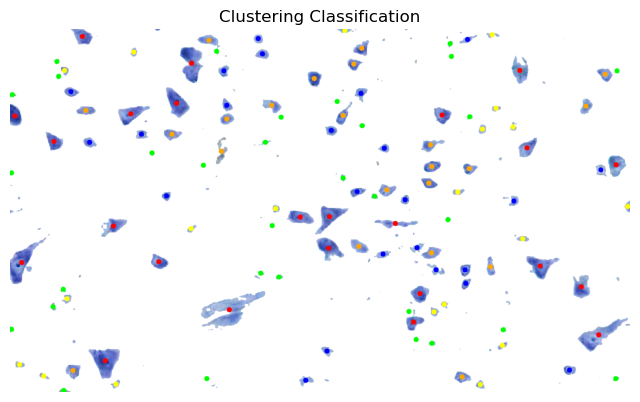

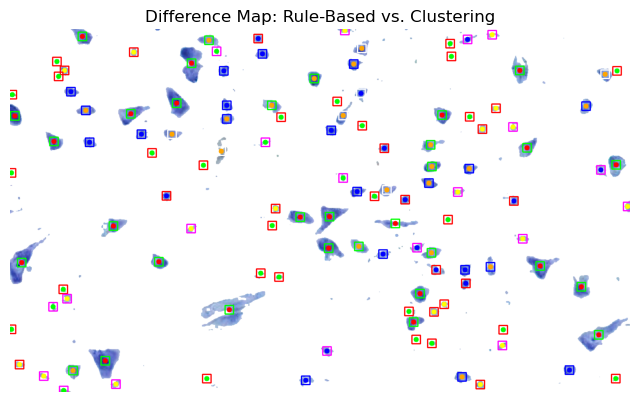

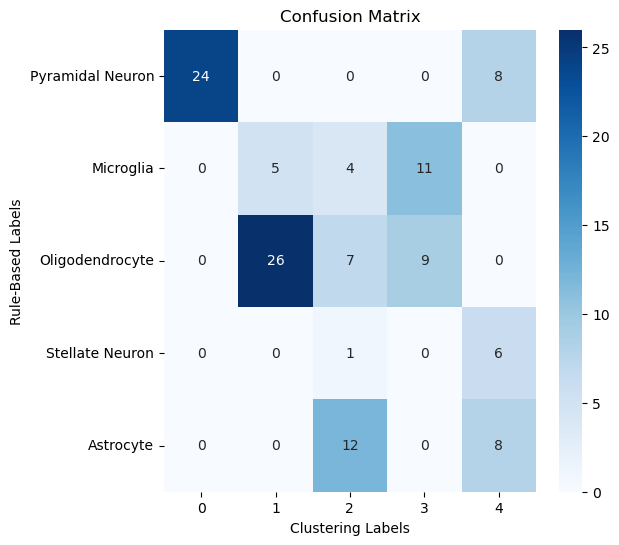

Chi-Square Test: χ² = 189.544, p = 0.00000
Kolmogorov-Smirnov Test: D = 0.124, p = 0.31129
Mann-Whitney U Test: U = 6811.000, p = 0.33786
Cohen’s Kappa Score: κ = 0.201


In [42]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import warnings
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from scipy.stats import chi2_contingency, ks_2samp, mannwhitneyu
import umap

# Ignore warnings
warnings.filterwarnings("ignore")

# ------------------- Load Data -------------------
df_features = pd.read_csv("data_cell_for_clustering.csv")  
df_centroids = pd.read_csv(r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\data_cell_with_centroids.csv")

df_rule_based = df_centroids[['Cell Number', 'Cell Type', 'X Centroid', 'Y Centroid']]

# Assign feature weights
feature_weights = {"Solidity": 3, "Circularity": 3, "Local_Homogeneity": 3, "Aspect Ratio": 3}

df_weighted = df_features.copy()
for col, weight in feature_weights.items():
    if col in df_weighted.columns:
        df_weighted[col] *= weight

# Extract feature matrix
features = df_weighted.iloc[:, 1:].values.astype(np.float32)
dim_features = features.shape[1]

features_tensor = torch.from_numpy(features)

# ------------------- Contrastive Clustering Model -------------------
class ContrastiveClustering(nn.Module):
    def __init__(self, input_dim, embedding_dim=128):
        super(ContrastiveClustering, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, embedding_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Initialize model
embedding_dim = 128
model = ContrastiveClustering(input_dim=dim_features, embedding_dim=embedding_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()
    reconstructed = model(features_tensor)
    loss = criterion(reconstructed, features_tensor)
    loss.backward()
    optimizer.step()

# Extract learned embeddings
with torch.no_grad():
    embeddings = model.encoder(features_tensor).numpy()

# UMAP for Dimensionality Reduction
umap_model = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
umap_embeddings = umap_model.fit_transform(embeddings)

# K-Means Clustering (n=5)
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
df_rule_based["Clustering Label"] = kmeans.fit_predict(umap_embeddings)

df_rule_based.to_csv("rule_vs_clustering_labels.csv", index=False)

# ------------------- Load Image -------------------
image_path = "restored_white_background_debug-Copy1.png"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Define colors
rule_based_colors = {
    "Astrocyte": (0, 0, 255),  # Red
    "Oligodendrocyte": (255, 0, 0),  # Blue
    "Microglia": (255, 0, 255),  # Purple
    "Pyramidal Neuron": (0, 255, 0),  # Green
    "Stellate Cell": (255, 165, 0)  # Orange
}

cluster_colors = {
    0: (255, 0, 0),  # Blue
    1: (0, 255, 0),  # Green
    2: (0, 0, 255),  # Red
    3: (255, 255, 0),  # Yellow
    4: (255, 165, 0)  # Orange
}

# ------------------- Generate & Display 3 Images -------------------

def save_and_show(image, filename, title):
    """Saves the image and displays it."""
    cv2.imwrite(filename, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    plt.figure(figsize=(8,8))
    plt.imshow(image)
    plt.title(title)
    plt.axis("off")
    plt.show()

# **1️⃣ Rule-Based Image (Bounding Boxes & Labels)**
rule_based_image = image.copy()
for _, row in df_rule_based.iterrows():
    x, y = int(row["X Centroid"]), int(row["Y Centroid"])
    cell_type = row["Cell Type"]
    color = rule_based_colors.get(cell_type, (255, 255, 255))
    cv2.rectangle(rule_based_image, (x - 10, y - 10), (x + 10, y + 10), color, 2)

save_and_show(rule_based_image, "rule_based_labeled.png", "Rule-Based Classification")

# **2️⃣ Clustering Image (Shaded Circles)**
clustering_image = image.copy()
for _, row in df_rule_based.iterrows():
    x, y = int(row["X Centroid"]), int(row["Y Centroid"])
    cluster_label = row["Clustering Label"]
    cv2.circle(clustering_image, (x, y), 6, cluster_colors.get(cluster_label, (255, 255, 255)), -1)

save_and_show(clustering_image, "clustering_labeled.png", "Clustering Classification")

# **3️⃣ Difference Map (Bounding Boxes + Circles)**
diff_map = image.copy()
for _, row in df_rule_based.iterrows():
    x, y = int(row["X Centroid"]), int(row["Y Centroid"])
    cell_type = row["Cell Type"]
    cluster_label = row["Clustering Label"]

    # Rule-based bounding box
    cv2.rectangle(diff_map, (x - 10, y - 10), (x + 10, y + 10), rule_based_colors.get(cell_type, (255, 255, 255)), 2)

    # Clustering shaded circle
    cv2.circle(diff_map, (x, y), 6, cluster_colors.get(cluster_label, (255, 255, 255)), -1)

save_and_show(diff_map, "difference_map.png", "Difference Map: Rule-Based vs. Clustering")

# ------------------- Confusion Matrix -------------------
plt.figure(figsize=(6, 6))
cell_types = df_rule_based["Cell Type"].unique()
cell_type_to_idx = {name: idx for idx, name in enumerate(cell_types)}
df_rule_based["Cell Type Index"] = df_rule_based["Cell Type"].map(cell_type_to_idx)

conf_matrix = confusion_matrix(df_rule_based["Cell Type Index"], df_rule_based["Clustering Label"])

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(5), yticklabels=cell_types)
plt.xlabel("Clustering Labels")
plt.ylabel("Rule-Based Labels")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")
plt.show()

# ------------------- Statistical Tests -------------------
chi2, p, _, _ = chi2_contingency(conf_matrix)
ks_stat, ks_pval = ks_2samp(df_rule_based["Cell Type Index"], df_rule_based["Clustering Label"])
mw_stat, mw_pval = mannwhitneyu(df_rule_based["Cell Type Index"], df_rule_based["Clustering Label"])
kappa = cohen_kappa_score(df_rule_based["Cell Type Index"], df_rule_based["Clustering Label"])

print(f"Chi-Square Test: χ² = {chi2:.3f}, p = {p:.5f}")
print(f"Kolmogorov-Smirnov Test: D = {ks_stat:.3f}, p = {ks_pval:.5f}")
print(f"Mann-Whitney U Test: U = {mw_stat:.3f}, p = {mw_pval:.5f}")
print(f"Cohen’s Kappa Score: κ = {kappa:.3f}")


### Rules base vs contrastive clustering for n=6 

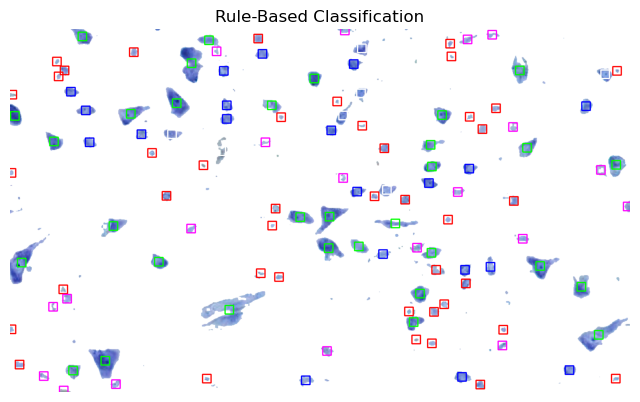

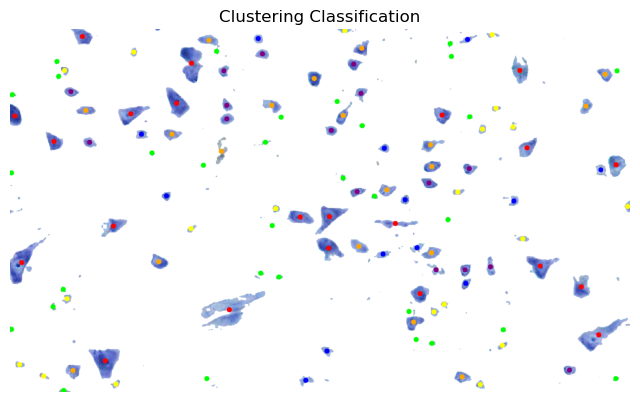

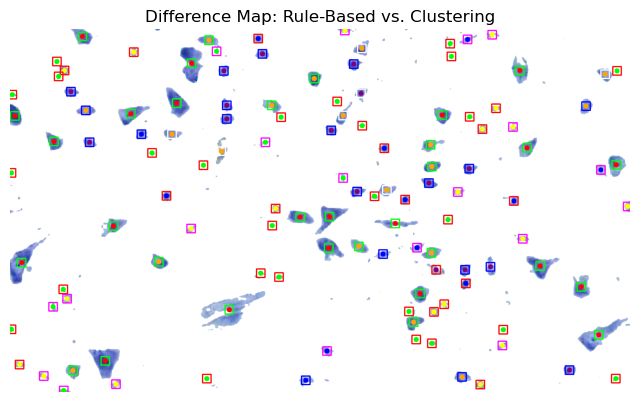

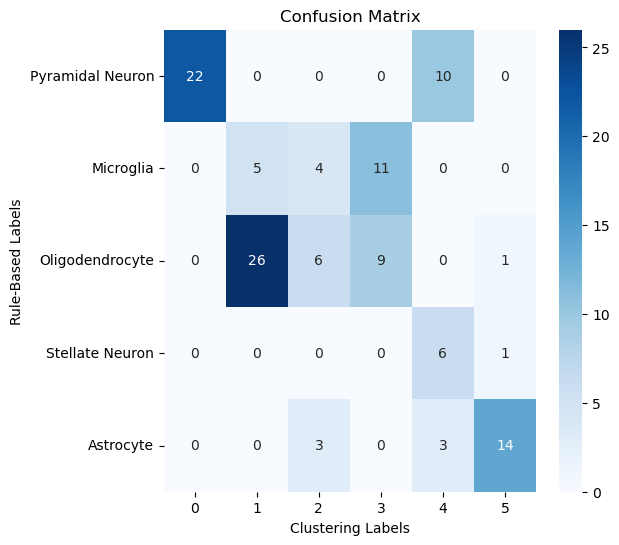

Chi-Square Test: χ² = 228.665, p = 0.00000
Kolmogorov-Smirnov Test: D = 0.231, p = 0.00297
Mann-Whitney U Test: U = 6043.000, p = 0.01679
Cohen’s Kappa Score: κ = 0.160


In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import warnings
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from scipy.stats import chi2_contingency, ks_2samp, mannwhitneyu
import umap

# Ignore warnings
warnings.filterwarnings("ignore")

# ------------------- Load Data -------------------
df_features = pd.read_csv("data_cell_for_clustering.csv")  
df_centroids = pd.read_csv(r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\data_cell_with_centroids.csv")

df_rule_based = df_centroids[['Cell Number', 'Cell Type', 'X Centroid', 'Y Centroid']]

# Assign feature weights
feature_weights = {"Solidity": 3, "Circularity": 3, "Local_Homogeneity": 3, "Aspect Ratio": 3}

df_weighted = df_features.copy()
for col, weight in feature_weights.items():
    if col in df_weighted.columns:
        df_weighted[col] *= weight

# Extract feature matrix
features = df_weighted.iloc[:, 1:].values.astype(np.float32)
dim_features = features.shape[1]

features_tensor = torch.from_numpy(features)

# ------------------- Contrastive Clustering Model -------------------
class ContrastiveClustering(nn.Module):
    def __init__(self, input_dim, embedding_dim=128):
        super(ContrastiveClustering, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, embedding_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Initialize model
embedding_dim = 128
model = ContrastiveClustering(input_dim=dim_features, embedding_dim=embedding_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()
    reconstructed = model(features_tensor)
    loss = criterion(reconstructed, features_tensor)
    loss.backward()
    optimizer.step()

# Extract learned embeddings
with torch.no_grad():
    embeddings = model.encoder(features_tensor).numpy()

# UMAP for Dimensionality Reduction
umap_model = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
umap_embeddings = umap_model.fit_transform(embeddings)

# K-Means Clustering (n=6)
kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)
df_rule_based["Clustering Label"] = kmeans.fit_predict(umap_embeddings)

df_rule_based.to_csv("rule_vs_clustering_labels_n6.csv", index=False)

# ------------------- Load Image -------------------
image_path = "restored_white_background_debug-Copy1.png"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Define colors
rule_based_colors = {
    "Astrocyte": (0, 0, 255),  # Red
    "Oligodendrocyte": (255, 0, 0),  # Blue
    "Microglia": (255, 0, 255),  # Purple
    "Pyramidal Neuron": (0, 255, 0),  # Green
    "Stellate Cell": (255, 165, 0)  # Orange
}

cluster_colors = {
    0: (255, 0, 0),  # Blue
    1: (0, 255, 0),  # Green
    2: (0, 0, 255),  # Red
    3: (255, 255, 0),  # Yellow
    4: (255, 165, 0),  # Orange
    5: (128, 0, 128)  # Purple
}

# ------------------- Generate & Display Images -------------------

def save_and_show(image, filename, title):
    """Saves the image and displays it."""
    cv2.imwrite(filename, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    plt.figure(figsize=(8,8))
    plt.imshow(image)
    plt.title(title)
    plt.axis("off")
    plt.show()

# **1️⃣ Rule-Based Image (Bounding Boxes & Labels)**
rule_based_image = image.copy()
for _, row in df_rule_based.iterrows():
    x, y = int(row["X Centroid"]), int(row["Y Centroid"])
    cell_type = row["Cell Type"]
    color = rule_based_colors.get(cell_type, (255, 255, 255))
    cv2.rectangle(rule_based_image, (x - 10, y - 10), (x + 10, y + 10), color, 2)

save_and_show(rule_based_image, "rule_based_labeled_n6.png", "Rule-Based Classification")

# **2️⃣ Clustering Image (Shaded Circles)**
clustering_image = image.copy()
for _, row in df_rule_based.iterrows():
    x, y = int(row["X Centroid"]), int(row["Y Centroid"])
    cluster_label = row["Clustering Label"]
    cv2.circle(clustering_image, (x, y), 6, cluster_colors.get(cluster_label, (255, 255, 255)), -1)

save_and_show(clustering_image, "clustering_labeled_n6.png", "Clustering Classification")

# **3️⃣ Difference Map (Bounding Boxes + Circles)**
diff_map = image.copy()
for _, row in df_rule_based.iterrows():
    x, y = int(row["X Centroid"]), int(row["Y Centroid"])
    cell_type = row["Cell Type"]
    cluster_label = row["Clustering Label"]

    # Rule-based bounding box
    cv2.rectangle(diff_map, (x - 10, y - 10), (x + 10, y + 10), rule_based_colors.get(cell_type, (255, 255, 255)), 2)

    # Clustering shaded circle
    cv2.circle(diff_map, (x, y), 6, cluster_colors.get(cluster_label, (255, 255, 255)), -1)

save_and_show(diff_map, "difference_map_n6.png", "Difference Map: Rule-Based vs. Clustering")

# ------------------- Confusion Matrix -------------------
plt.figure(figsize=(6, 6))
cell_types = df_rule_based["Cell Type"].unique()
cell_type_to_idx = {name: idx for idx, name in enumerate(cell_types)}
df_rule_based["Cell Type Index"] = df_rule_based["Cell Type"].map(cell_type_to_idx)

conf_matrix = confusion_matrix(df_rule_based["Cell Type Index"], df_rule_based["Clustering Label"])

# Filter out rows and columns with zero values in the confusion matrix
conf_matrix = conf_matrix[(conf_matrix.sum(axis=1) > 0), :]  # Remove rows with zero sums
conf_matrix = conf_matrix[:, (conf_matrix.sum(axis=0) > 0)]  # Remove columns with zero sums

# Plot confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(conf_matrix.shape[1]), yticklabels=cell_types)
plt.xlabel("Clustering Labels")
plt.ylabel("Rule-Based Labels")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix_n6.png")
plt.show()

# ------------------- Statistical Tests -------------------
# Chi-Square Test (with filtered confusion matrix)
chi2, p, _, _ = chi2_contingency(conf_matrix)
ks_stat, ks_pval = ks_2samp(df_rule_based["Cell Type Index"], df_rule_based["Clustering Label"])
mw_stat, mw_pval = mannwhitneyu(df_rule_based["Cell Type Index"], df_rule_based["Clustering Label"])
kappa = cohen_kappa_score(df_rule_based["Cell Type Index"], df_rule_based["Clustering Label"])

print(f"Chi-Square Test: χ² = {chi2:.3f}, p = {p:.5f}")
print(f"Kolmogorov-Smirnov Test: D = {ks_stat:.3f}, p = {ks_pval:.5f}")
print(f"Mann-Whitney U Test: U = {mw_stat:.3f}, p = {mw_pval:.5f}")
print(f"Cohen’s Kappa Score: κ = {kappa:.3f}")


### Rules base vs contrastive clustering for n=7

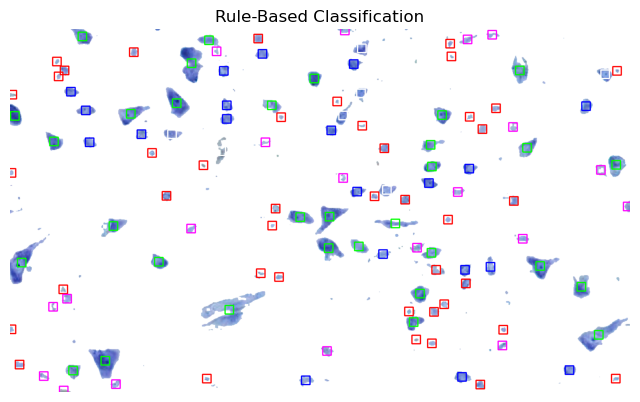

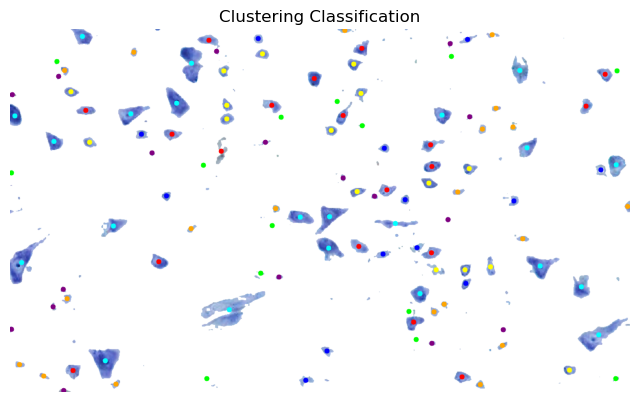

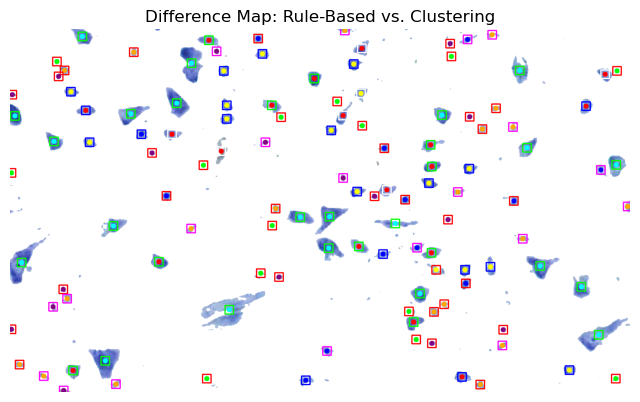

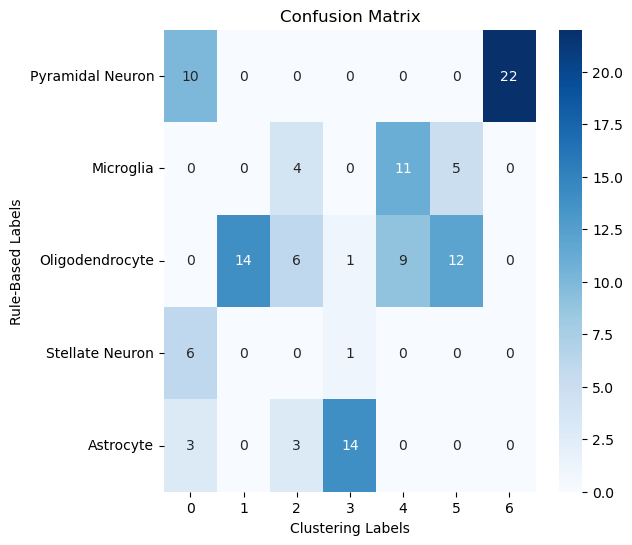

Chi-Square Test: χ² = 234.596, p = 0.00000
Kolmogorov-Smirnov Test: D = 0.397, p = 0.00000
Mann-Whitney U Test: U = 4301.000, p = 0.00000
Cohen’s Kappa Score: κ = 0.009


In [5]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import warnings
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from scipy.stats import chi2_contingency, ks_2samp, mannwhitneyu
import umap

# Ignore warnings
warnings.filterwarnings("ignore")

# ------------------- Load Data -------------------
df_features = pd.read_csv("data_cell_for_clustering.csv")  
df_centroids = pd.read_csv(r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\data_cell_with_centroids.csv")

df_rule_based = df_centroids[['Cell Number', 'Cell Type', 'X Centroid', 'Y Centroid']]

# Assign feature weights
feature_weights = {"Solidity": 3, "Circularity": 3, "Local_Homogeneity": 3, "Aspect Ratio": 3}

df_weighted = df_features.copy()
for col, weight in feature_weights.items():
    if col in df_weighted.columns:
        df_weighted[col] *= weight

# Extract feature matrix
features = df_weighted.iloc[:, 1:].values.astype(np.float32)
dim_features = features.shape[1]

features_tensor = torch.from_numpy(features)

# ------------------- Contrastive Clustering Model -------------------
class ContrastiveClustering(nn.Module):
    def __init__(self, input_dim, embedding_dim=128):
        super(ContrastiveClustering, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, embedding_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Initialize model
embedding_dim = 128
model = ContrastiveClustering(input_dim=dim_features, embedding_dim=embedding_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()
    reconstructed = model(features_tensor)
    loss = criterion(reconstructed, features_tensor)
    loss.backward()
    optimizer.step()

# Extract learned embeddings
with torch.no_grad():
    embeddings = model.encoder(features_tensor).numpy()

# UMAP for Dimensionality Reduction
umap_model = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
umap_embeddings = umap_model.fit_transform(embeddings)

# K-Means Clustering (n=7)
kmeans = KMeans(n_clusters=7, random_state=42, n_init=10)
df_rule_based["Clustering Label"] = kmeans.fit_predict(umap_embeddings)

df_rule_based.to_csv("rule_vs_clustering_labels_n7.csv", index=False)

# ------------------- Load Image -------------------
image_path = "restored_white_background_debug-Copy1.png"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Define colors for 7 clusters
rule_based_colors = {
    "Astrocyte": (0, 0, 255),  # Red
    "Oligodendrocyte": (255, 0, 0),  # Blue
    "Microglia": (255, 0, 255),  # Purple
    "Pyramidal Neuron": (0, 255, 0),  # Green
    "Stellate Cell": (255, 165, 0)  # Orange
}

cluster_colors = {
    0: (255, 0, 0),  # Blue
    1: (0, 255, 0),  # Green
    2: (0, 0, 255),  # Red
    3: (255, 255, 0),  # Yellow
    4: (255, 165, 0),  # Orange
    5: (128, 0, 128),  # Purple
    6: (0, 255, 255)   # Cyan
}

# ------------------- Generate & Display Images -------------------

def save_and_show(image, filename, title):
    """Saves the image and displays it."""
    cv2.imwrite(filename, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    plt.figure(figsize=(8,8))
    plt.imshow(image)
    plt.title(title)
    plt.axis("off")
    plt.show()

# **1️⃣ Rule-Based Image (Bounding Boxes & Labels)**
rule_based_image = image.copy()
for _, row in df_rule_based.iterrows():
    x, y = int(row["X Centroid"]), int(row["Y Centroid"])
    cell_type = row["Cell Type"]
    color = rule_based_colors.get(cell_type, (255, 255, 255))
    cv2.rectangle(rule_based_image, (x - 10, y - 10), (x + 10, y + 10), color, 2)

save_and_show(rule_based_image, "rule_based_labeled_n7.png", "Rule-Based Classification")

# **2️⃣ Clustering Image (Shaded Circles)**
clustering_image = image.copy()
for _, row in df_rule_based.iterrows():
    x, y = int(row["X Centroid"]), int(row["Y Centroid"])
    cluster_label = row["Clustering Label"]
    cv2.circle(clustering_image, (x, y), 6, cluster_colors.get(cluster_label, (255, 255, 255)), -1)

save_and_show(clustering_image, "clustering_labeled_n7.png", "Clustering Classification")

# **3️⃣ Difference Map (Bounding Boxes + Circles)**
diff_map = image.copy()
for _, row in df_rule_based.iterrows():
    x, y = int(row["X Centroid"]), int(row["Y Centroid"])
    cell_type = row["Cell Type"]
    cluster_label = row["Clustering Label"]

    # Rule-based bounding box
    cv2.rectangle(diff_map, (x - 10, y - 10), (x + 10, y + 10), rule_based_colors.get(cell_type, (255, 255, 255)), 2)

    # Clustering shaded circle
    cv2.circle(diff_map, (x, y), 6, cluster_colors.get(cluster_label, (255, 255, 255)), -1)

save_and_show(diff_map, "difference_map_n7.png", "Difference Map: Rule-Based vs. Clustering")

# ------------------- Confusion Matrix -------------------
plt.figure(figsize=(6, 6))
cell_types = df_rule_based["Cell Type"].unique()
cell_type_to_idx = {name: idx for idx, name in enumerate(cell_types)}
df_rule_based["Cell Type Index"] = df_rule_based["Cell Type"].map(cell_type_to_idx)

conf_matrix = confusion_matrix(df_rule_based["Cell Type Index"], df_rule_based["Clustering Label"])

# Filter out rows and columns with zero values in the confusion matrix
conf_matrix = conf_matrix[(conf_matrix.sum(axis=1) > 0), :]  # Remove rows with zero sums
conf_matrix = conf_matrix[:, (conf_matrix.sum(axis=0) > 0)]  # Remove columns with zero sums

# Plot confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(conf_matrix.shape[1]), yticklabels=cell_types)
plt.xlabel("Clustering Labels")
plt.ylabel("Rule-Based Labels")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix_n7.png")
plt.show()

# ------------------- Statistical Tests -------------------
# Chi-Square Test (with filtered confusion matrix)
chi2, p, _, _ = chi2_contingency(conf_matrix)
ks_stat, ks_pval = ks_2samp(df_rule_based["Cell Type Index"], df_rule_based["Clustering Label"])
mw_stat, mw_pval = mannwhitneyu(df_rule_based["Cell Type Index"], df_rule_based["Clustering Label"])
kappa = cohen_kappa_score(df_rule_based["Cell Type Index"], df_rule_based["Clustering Label"])

print(f"Chi-Square Test: χ² = {chi2:.3f}, p = {p:.5f}")
print(f"Kolmogorov-Smirnov Test: D = {ks_stat:.3f}, p = {ks_pval:.5f}")
print(f"Mann-Whitney U Test: U = {mw_stat:.3f}, p = {mw_pval:.5f}")
print(f"Cohen’s Kappa Score: κ = {kappa:.3f}")


### Rules base vs contrastive clustering for n=8 

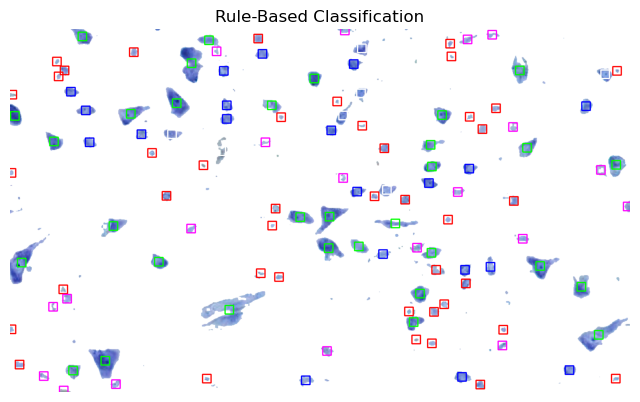

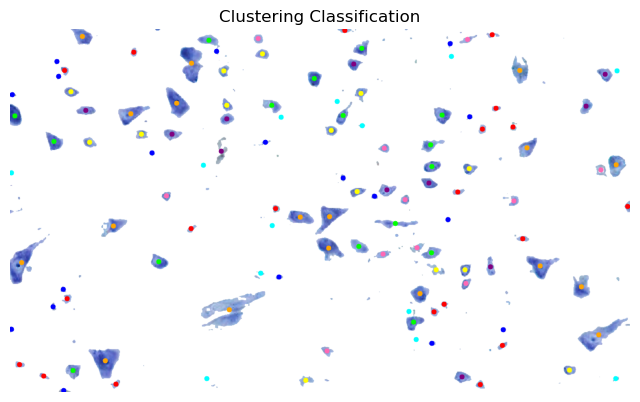

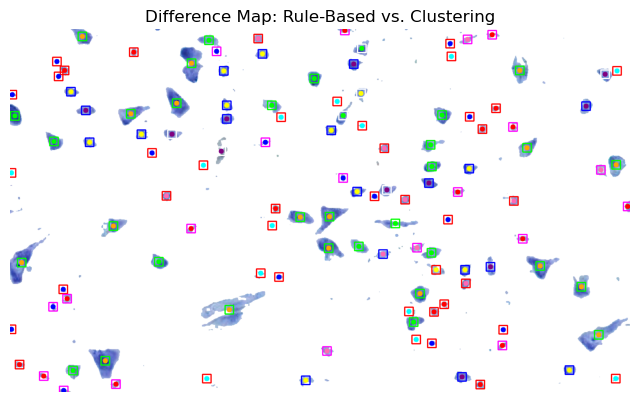

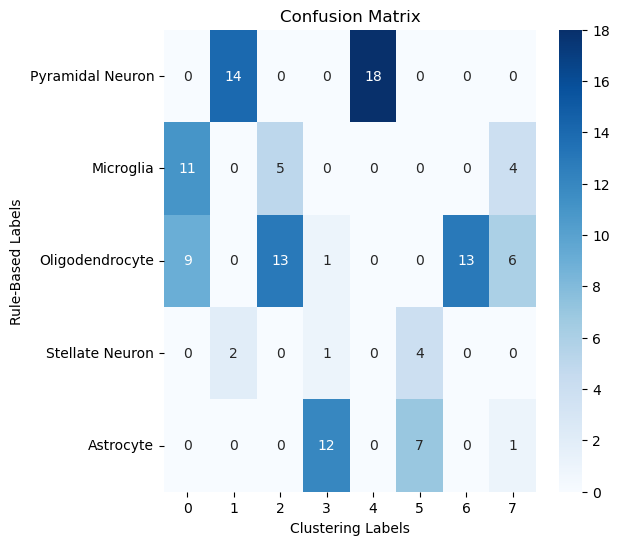

Chi-Square Test: χ² = 253.419, p = 0.00000
Kolmogorov-Smirnov Test: D = 0.331, p = 0.00000
Mann-Whitney U Test: U = 4737.000, p = 0.00000
Cohen’s Kappa Score: κ = -0.039


In [7]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import warnings
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from scipy.stats import chi2_contingency, ks_2samp, mannwhitneyu
import umap

# Ignore warnings
warnings.filterwarnings("ignore")

# ------------------- Load Data -------------------
df_features = pd.read_csv("data_cell_for_clustering.csv")  
df_centroids = pd.read_csv(r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\data_cell_with_centroids.csv")

df_rule_based = df_centroids[['Cell Number', 'Cell Type', 'X Centroid', 'Y Centroid']]

# Assign feature weights
feature_weights = {"Solidity": 3, "Circularity": 3, "Local_Homogeneity": 3, "Aspect Ratio": 3}

df_weighted = df_features.copy()
for col, weight in feature_weights.items():
    if col in df_weighted.columns:
        df_weighted[col] *= weight

# Extract feature matrix
features = df_weighted.iloc[:, 1:].values.astype(np.float32)
dim_features = features.shape[1]

features_tensor = torch.from_numpy(features)

# ------------------- Contrastive Clustering Model -------------------
class ContrastiveClustering(nn.Module):
    def __init__(self, input_dim, embedding_dim=128):
        super(ContrastiveClustering, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, embedding_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Initialize model
embedding_dim = 128
model = ContrastiveClustering(input_dim=dim_features, embedding_dim=embedding_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()
    reconstructed = model(features_tensor)
    loss = criterion(reconstructed, features_tensor)
    loss.backward()
    optimizer.step()

# Extract learned embeddings
with torch.no_grad():
    embeddings = model.encoder(features_tensor).numpy()

# UMAP for Dimensionality Reduction
umap_model = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
umap_embeddings = umap_model.fit_transform(embeddings)

# K-Means Clustering (n=8)
kmeans = KMeans(n_clusters=8, random_state=42, n_init=10)
df_rule_based["Clustering Label"] = kmeans.fit_predict(umap_embeddings)

df_rule_based.to_csv("rule_vs_clustering_labels_n8.csv", index=False)

# ------------------- Load Image -------------------
image_path = "restored_white_background_debug-Copy1.png"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Define colors for 8 clusters
rule_based_colors = {
    "Astrocyte": (0, 0, 255),  # Red
    "Oligodendrocyte": (255, 0, 0),  # Blue
    "Microglia": (255, 0, 255),  # Purple
    "Pyramidal Neuron": (0, 255, 0),  # Green
    "Stellate Cell": (255, 165, 0)  # Orange
}

cluster_colors = {
    0: (255, 0, 0),  # Blue
    1: (0, 255, 0),  # Green
    2: (0, 0, 255),  # Red
    3: (255, 255, 0),  # Yellow
    4: (255, 165, 0),  # Orange
    5: (128, 0, 128),  # Purple
    6: (0, 255, 255),  # Cyan
    7: (255, 105, 180)  # Hot Pink
}

# ------------------- Generate & Display Images -------------------

def save_and_show(image, filename, title):
    """Saves the image and displays it."""
    cv2.imwrite(filename, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    plt.figure(figsize=(8,8))
    plt.imshow(image)
    plt.title(title)
    plt.axis("off")
    plt.show()

# **1️⃣ Rule-Based Image (Bounding Boxes & Labels)**
rule_based_image = image.copy()
for _, row in df_rule_based.iterrows():
    x, y = int(row["X Centroid"]), int(row["Y Centroid"])
    cell_type = row["Cell Type"]
    color = rule_based_colors.get(cell_type, (255, 255, 255))
    cv2.rectangle(rule_based_image, (x - 10, y - 10), (x + 10, y + 10), color, 2)

save_and_show(rule_based_image, "rule_based_labeled_n8.png", "Rule-Based Classification")

# **2️⃣ Clustering Image (Shaded Circles)**
clustering_image = image.copy()
for _, row in df_rule_based.iterrows():
    x, y = int(row["X Centroid"]), int(row["Y Centroid"])
    cluster_label = row["Clustering Label"]
    cv2.circle(clustering_image, (x, y), 6, cluster_colors.get(cluster_label, (255, 255, 255)), -1)

save_and_show(clustering_image, "clustering_labeled_n8.png", "Clustering Classification")

# **3️⃣ Difference Map (Bounding Boxes + Circles)**
diff_map = image.copy()
for _, row in df_rule_based.iterrows():
    x, y = int(row["X Centroid"]), int(row["Y Centroid"])
    cell_type = row["Cell Type"]
    cluster_label = row["Clustering Label"]

    # Rule-based bounding box
    cv2.rectangle(diff_map, (x - 10, y - 10), (x + 10, y + 10), rule_based_colors.get(cell_type, (255, 255, 255)), 2)

    # Clustering shaded circle
    cv2.circle(diff_map, (x, y), 6, cluster_colors.get(cluster_label, (255, 255, 255)), -1)

save_and_show(diff_map, "difference_map_n8.png", "Difference Map: Rule-Based vs. Clustering")

# ------------------- Confusion Matrix -------------------
plt.figure(figsize=(6, 6))
cell_types = df_rule_based["Cell Type"].unique()
cell_type_to_idx = {name: idx for idx, name in enumerate(cell_types)}
df_rule_based["Cell Type Index"] = df_rule_based["Cell Type"].map(cell_type_to_idx)

conf_matrix = confusion_matrix(df_rule_based["Cell Type Index"], df_rule_based["Clustering Label"])

# Filter out rows and columns with zero values in the confusion matrix
conf_matrix = conf_matrix[(conf_matrix.sum(axis=1) > 0), :]  # Remove rows with zero sums
conf_matrix = conf_matrix[:, (conf_matrix.sum(axis=0) > 0)]  # Remove columns with zero sums

# Plot confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(conf_matrix.shape[1]), yticklabels=cell_types)
plt.xlabel("Clustering Labels")
plt.ylabel("Rule-Based Labels")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix_n8.png")
plt.show()

# ------------------- Statistical Tests -------------------
# Chi-Square Test (with filtered confusion matrix)
chi2, p, _, _ = chi2_contingency(conf_matrix)
ks_stat, ks_pval = ks_2samp(df_rule_based["Cell Type Index"], df_rule_based["Clustering Label"])
mw_stat, mw_pval = mannwhitneyu(df_rule_based["Cell Type Index"], df_rule_based["Clustering Label"])
kappa = cohen_kappa_score(df_rule_based["Cell Type Index"], df_rule_based["Clustering Label"])

print(f"Chi-Square Test: χ² = {chi2:.3f}, p = {p:.5f}")
print(f"Kolmogorov-Smirnov Test: D = {ks_stat:.3f}, p = {ks_pval:.5f}")
print(f"Mann-Whitney U Test: U = {mw_stat:.3f}, p = {mw_pval:.5f}")
print(f"Cohen’s Kappa Score: κ = {kappa:.3f}")


### Rules base vs contrastive clustering for n=9

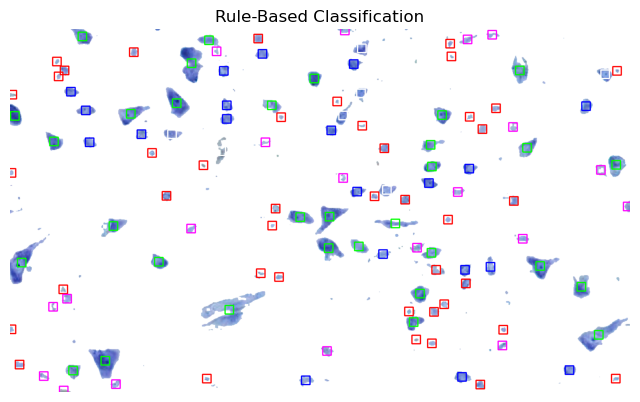

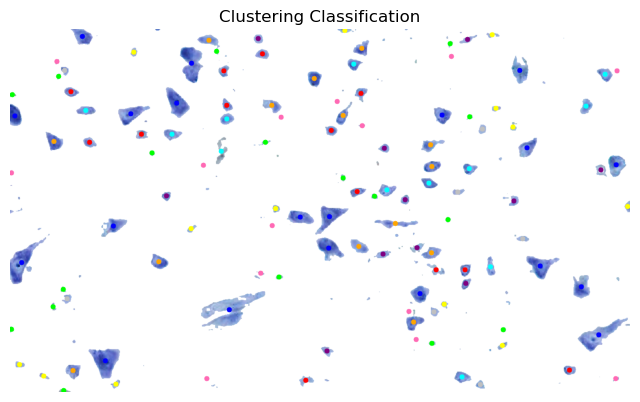

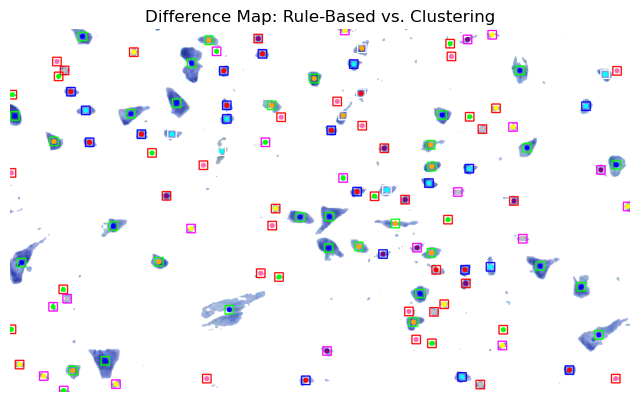

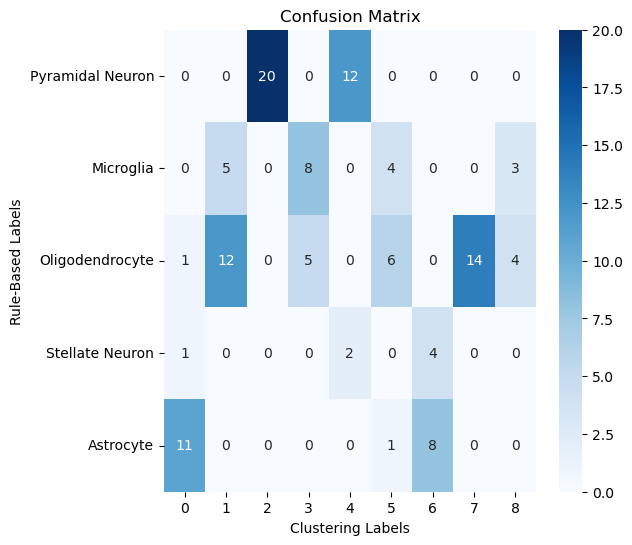

Chi-Square Test: χ² = 253.735, p = 0.00000
Kolmogorov-Smirnov Test: D = 0.364, p = 0.00000
Mann-Whitney U Test: U = 4113.500, p = 0.00000
Cohen’s Kappa Score: κ = -0.107


In [12]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import warnings
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from scipy.stats import chi2_contingency, ks_2samp, mannwhitneyu
import umap

# Ignore warnings
warnings.filterwarnings("ignore")

# ------------------- Load Data -------------------
df_features = pd.read_csv("data_cell_for_clustering.csv")  
df_centroids = pd.read_csv(r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\data_cell_with_centroids.csv")

df_rule_based = df_centroids[['Cell Number', 'Cell Type', 'X Centroid', 'Y Centroid']]

# Assign feature weights
feature_weights = {"Solidity": 3, "Circularity": 3, "Local_Homogeneity": 3, "Aspect Ratio": 3}

df_weighted = df_features.copy()
for col, weight in feature_weights.items():
    if col in df_weighted.columns:
        df_weighted[col] *= weight

# Extract feature matrix
features = df_weighted.iloc[:, 1:].values.astype(np.float32)
dim_features = features.shape[1]

features_tensor = torch.from_numpy(features)

# ------------------- Contrastive Clustering Model -------------------
class ContrastiveClustering(nn.Module):
    def __init__(self, input_dim, embedding_dim=128):
        super(ContrastiveClustering, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, embedding_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Initialize model
embedding_dim = 128
model = ContrastiveClustering(input_dim=dim_features, embedding_dim=embedding_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()
    reconstructed = model(features_tensor)
    loss = criterion(reconstructed, features_tensor)
    loss.backward()
    optimizer.step()

# Extract learned embeddings
with torch.no_grad():
    embeddings = model.encoder(features_tensor).numpy()

# UMAP for Dimensionality Reduction
umap_model = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
umap_embeddings = umap_model.fit_transform(embeddings)

# K-Means Clustering (n=9)
kmeans = KMeans(n_clusters=9, random_state=42, n_init=10)
df_rule_based["Clustering Label"] = kmeans.fit_predict(umap_embeddings)

df_rule_based.to_csv("rule_vs_clustering_labels_n9.csv", index=False)

# ------------------- Load Image -------------------
image_path = "restored_white_background_debug-Copy1.png"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Define colors for 9 clusters
rule_based_colors = {
    "Astrocyte": (0, 0, 255),  # Red
    "Oligodendrocyte": (255, 0, 0),  # Blue
    "Microglia": (255, 0, 255),  # Purple
    "Pyramidal Neuron": (0, 255, 0),  # Green
    "Stellate Cell": (255, 165, 0)  # Orange
}

cluster_colors = {
    0: (255, 0, 0),  # Blue
    1: (0, 255, 0),  # Green
    2: (0, 0, 255),  # Red
    3: (255, 255, 0),  # Yellow
    4: (255, 165, 0),  # Orange
    5: (128, 0, 128),  # Purple
    6: (0, 255, 255),  # Cyan
    7: (255, 105, 180),  # Hot Pink
    8: (192, 192, 192),  # Light Gray
}

# ------------------- Generate & Display Images -------------------

def save_and_show(image, filename, title):
    """Saves the image and displays it."""
    cv2.imwrite(filename, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    plt.figure(figsize=(8,8))
    plt.imshow(image)
    plt.title(title)
    plt.axis("off")
    plt.show()

# **1️⃣ Rule-Based Image (Bounding Boxes & Labels)**
rule_based_image = image.copy()
for _, row in df_rule_based.iterrows():
    x, y = int(row["X Centroid"]), int(row["Y Centroid"])
    cell_type = row["Cell Type"]
    color = rule_based_colors.get(cell_type, (255, 255, 255))
    cv2.rectangle(rule_based_image, (x - 10, y - 10), (x + 10, y + 10), color, 2)

save_and_show(rule_based_image, "rule_based_labeled_n9.png", "Rule-Based Classification")

# **2️⃣ Clustering Image (Shaded Circles)**
clustering_image = image.copy()
for _, row in df_rule_based.iterrows():
    x, y = int(row["X Centroid"]), int(row["Y Centroid"])
    cluster_label = row["Clustering Label"]
    cv2.circle(clustering_image, (x, y), 6, cluster_colors.get(cluster_label, (255, 255, 255)), -1)

save_and_show(clustering_image, "clustering_labeled_n9.png", "Clustering Classification")

# **3️⃣ Difference Map (Bounding Boxes + Circles)**
diff_map = image.copy()
for _, row in df_rule_based.iterrows():
    x, y = int(row["X Centroid"]), int(row["Y Centroid"])
    cell_type = row["Cell Type"]
    cluster_label = row["Clustering Label"]

    # Rule-based bounding box
    cv2.rectangle(diff_map, (x - 10, y - 10), (x + 10, y + 10), rule_based_colors.get(cell_type, (255, 255, 255)), 2)

    # Clustering shaded circle
    cv2.circle(diff_map, (x, y), 6, cluster_colors.get(cluster_label, (255, 255, 255)), -1)

save_and_show(diff_map, "difference_map_n9.png", "Difference Map: Rule-Based vs. Clustering")

# ------------------- Confusion Matrix -------------------
plt.figure(figsize=(6, 6))
cell_types = df_rule_based["Cell Type"].unique()
cell_type_to_idx = {name: idx for idx, name in enumerate(cell_types)}
df_rule_based["Cell Type Index"] = df_rule_based["Cell Type"].map(cell_type_to_idx)

conf_matrix = confusion_matrix(df_rule_based["Cell Type Index"], df_rule_based["Clustering Label"])

# Filter out rows and columns with zero values in the confusion matrix
conf_matrix = conf_matrix[(conf_matrix.sum(axis=1) > 0), :]  # Remove rows with zero sums
conf_matrix = conf_matrix[:, (conf_matrix.sum(axis=0) > 0)]  # Remove columns with zero sums

# Plot confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(conf_matrix.shape[1]), yticklabels=cell_types)
plt.xlabel("Clustering Labels")
plt.ylabel("Rule-Based Labels")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix_n9.png")
plt.show()

# ------------------- Statistical Tests -------------------
# Chi-Square Test (with filtered confusion matrix)
chi2, p, _, _ = chi2_contingency(conf_matrix)
ks_stat, ks_pval = ks_2samp(df_rule_based["Cell Type Index"], df_rule_based["Clustering Label"])
mw_stat, mw_pval = mannwhitneyu(df_rule_based["Cell Type Index"], df_rule_based["Clustering Label"])
kappa = cohen_kappa_score(df_rule_based["Cell Type Index"], df_rule_based["Clustering Label"])

print(f"Chi-Square Test: χ² = {chi2:.3f}, p = {p:.5f}")
print(f"Kolmogorov-Smirnov Test: D = {ks_stat:.3f}, p = {ks_pval:.5f}")
print(f"Mann-Whitney U Test: U = {mw_stat:.3f}, p = {mw_pval:.5f}")
print(f"Cohen’s Kappa Score: κ = {kappa:.3f}")



### Rules base vs contrastive clustering for n=10

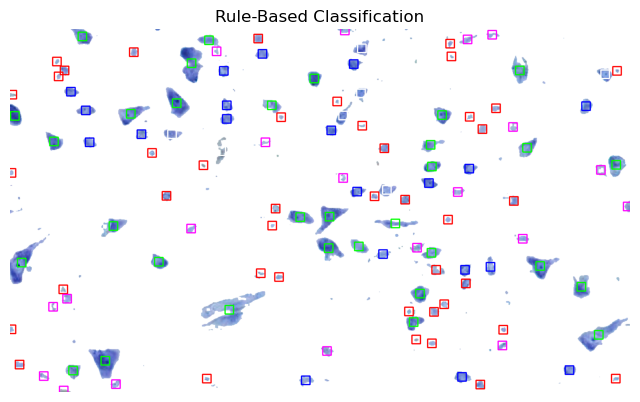

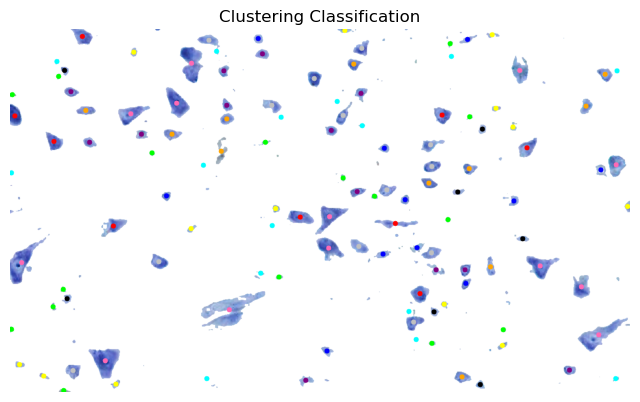

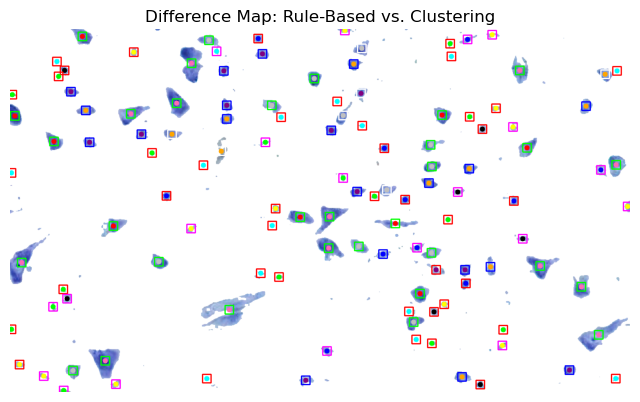

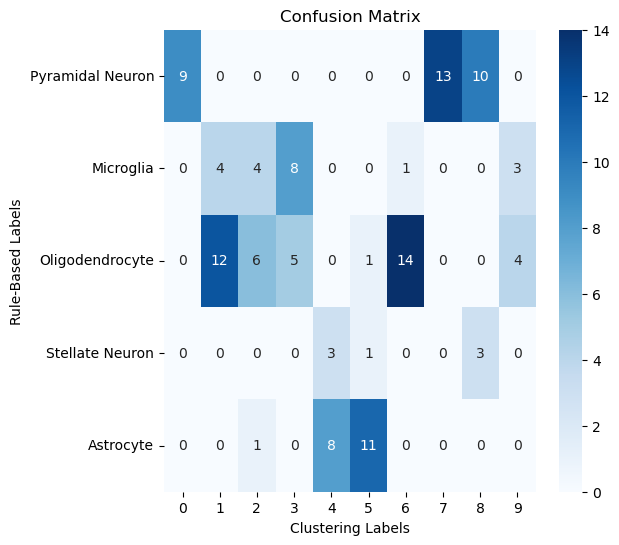

Chi-Square Test: χ² = 248.940, p = 0.00000
Kolmogorov-Smirnov Test: D = 0.504, p = 0.00000
Mann-Whitney U Test: U = 3152.500, p = 0.00000
Cohen’s Kappa Score: κ = 0.142


In [18]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import warnings
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from scipy.stats import chi2_contingency, ks_2samp, mannwhitneyu
import umap

# Ignore warnings
warnings.filterwarnings("ignore")

# ------------------- Load Data -------------------
df_features = pd.read_csv("data_cell_for_clustering.csv")  
df_centroids = pd.read_csv(r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\data_cell_with_centroids.csv")

df_rule_based = df_centroids[['Cell Number', 'Cell Type', 'X Centroid', 'Y Centroid']]

# Assign feature weights
feature_weights = {"Solidity": 3, "Circularity": 3, "Local_Homogeneity": 3, "Aspect Ratio": 3}

df_weighted = df_features.copy()
for col, weight in feature_weights.items():
    if col in df_weighted.columns:
        df_weighted[col] *= weight

# Extract feature matrix
features = df_weighted.iloc[:, 1:].values.astype(np.float32)
dim_features = features.shape[1]

features_tensor = torch.from_numpy(features)

# ------------------- Contrastive Clustering Model -------------------
class ContrastiveClustering(nn.Module):
    def __init__(self, input_dim, embedding_dim=128):
        super(ContrastiveClustering, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, embedding_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Initialize model
embedding_dim = 128
model = ContrastiveClustering(input_dim=dim_features, embedding_dim=embedding_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()
    reconstructed = model(features_tensor)
    loss = criterion(reconstructed, features_tensor)
    loss.backward()
    optimizer.step()

# Extract learned embeddings
with torch.no_grad():
    embeddings = model.encoder(features_tensor).numpy()

# UMAP for Dimensionality Reduction
umap_model = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
umap_embeddings = umap_model.fit_transform(embeddings)

# K-Means Clustering (n=10)
kmeans = KMeans(n_clusters=10, random_state=42, n_init=10)
df_rule_based["Clustering Label"] = kmeans.fit_predict(umap_embeddings)

df_rule_based.to_csv("rule_vs_clustering_labels_n10.csv", index=False)

# ------------------- Load Image -------------------
image_path = "restored_white_background_debug-Copy1.png"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Define colors for 10 clusters
rule_based_colors = {
    "Astrocyte": (0, 0, 255),  # Red
    "Oligodendrocyte": (255, 0, 0),  # Blue
    "Microglia": (255, 0, 255),  # Purple
    "Pyramidal Neuron": (0, 255, 0),  # Green
    "Stellate Cell": (255, 165, 0)  # Orange
}

cluster_colors = {
    0: (255, 0, 0),  # Blue
    1: (0, 255, 0),  # Green
    2: (0, 0, 255),  # Red
    3: (255, 255, 0),  # Yellow
    4: (255, 165, 0),  # Orange
    5: (128, 0, 128),  # Purple
    6: (0, 255, 255),  # Cyan
    7: (255, 105, 180),  # Hot Pink
    8: (192, 192, 192),  # Light Gray
    9: (0, 0, 0),  # Black
}

# ------------------- Generate & Display Images -------------------

def save_and_show(image, filename, title):
    """Saves the image and displays it."""
    cv2.imwrite(filename, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    plt.figure(figsize=(8,8))
    plt.imshow(image)
    plt.title(title)
    plt.axis("off")
    plt.show()

# **1️⃣ Rule-Based Image (Bounding Boxes & Labels)**
rule_based_image = image.copy()
for _, row in df_rule_based.iterrows():
    x, y = int(row["X Centroid"]), int(row["Y Centroid"])
    cell_type = row["Cell Type"]
    color = rule_based_colors.get(cell_type, (255, 255, 255))
    cv2.rectangle(rule_based_image, (x - 10, y - 10), (x + 10, y + 10), color, 2)

save_and_show(rule_based_image, "rule_based_labeled_n10.png", "Rule-Based Classification")

# **2️⃣ Clustering Image (Shaded Circles)**
clustering_image = image.copy()
for _, row in df_rule_based.iterrows():
    x, y = int(row["X Centroid"]), int(row["Y Centroid"])
    cluster_label = row["Clustering Label"]
    cv2.circle(clustering_image, (x, y), 6, cluster_colors.get(cluster_label, (255, 255, 255)), -1)

save_and_show(clustering_image, "clustering_labeled_n10.png", "Clustering Classification")

# **3️⃣ Difference Map (Bounding Boxes + Circles)**
diff_map = image.copy()
for _, row in df_rule_based.iterrows():
    x, y = int(row["X Centroid"]), int(row["Y Centroid"])
    cell_type = row["Cell Type"]
    cluster_label = row["Clustering Label"]

    # Rule-based bounding box
    cv2.rectangle(diff_map, (x - 10, y - 10), (x + 10, y + 10), rule_based_colors.get(cell_type, (255, 255, 255)), 2)

    # Clustering shaded circle
    cv2.circle(diff_map, (x, y), 6, cluster_colors.get(cluster_label, (255, 255, 255)), -1)

save_and_show(diff_map, "difference_map_n10.png", "Difference Map: Rule-Based vs. Clustering")

# ------------------- Confusion Matrix -------------------
plt.figure(figsize=(6, 6))
cell_types = df_rule_based["Cell Type"].unique()
cell_type_to_idx = {name: idx for idx, name in enumerate(cell_types)}
df_rule_based["Cell Type Index"] = df_rule_based["Cell Type"].map(cell_type_to_idx)

conf_matrix = confusion_matrix(df_rule_based["Cell Type Index"], df_rule_based["Clustering Label"])

# Filter out rows and columns with zero values in the confusion matrix
conf_matrix = conf_matrix[(conf_matrix.sum(axis=1) > 0), :]  # Remove rows with zero sums
conf_matrix = conf_matrix[:, (conf_matrix.sum(axis=0) > 0)]  # Remove columns with zero sums

# Plot confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(conf_matrix.shape[1]), yticklabels=cell_types)
plt.xlabel("Clustering Labels")
plt.ylabel("Rule-Based Labels")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix_n10.png")
plt.show()

# ------------------- Statistical Tests -------------------
# Chi-Square Test (with filtered confusion matrix)
chi2, p, _, _ = chi2_contingency(conf_matrix)
ks_stat, ks_pval = ks_2samp(df_rule_based["Cell Type Index"], df_rule_based["Clustering Label"])
mw_stat, mw_pval = mannwhitneyu(df_rule_based["Cell Type Index"], df_rule_based["Clustering Label"])
kappa = cohen_kappa_score(df_rule_based["Cell Type Index"], df_rule_based["Clustering Label"])

print(f"Chi-Square Test: χ² = {chi2:.3f}, p = {p:.5f}")
print(f"Kolmogorov-Smirnov Test: D = {ks_stat:.3f}, p = {ks_pval:.5f}")
print(f"Mann-Whitney U Test: U = {mw_stat:.3f}, p = {mw_pval:.5f}")
print(f"Cohen’s Kappa Score: κ = {kappa:.3f}")



In [3]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

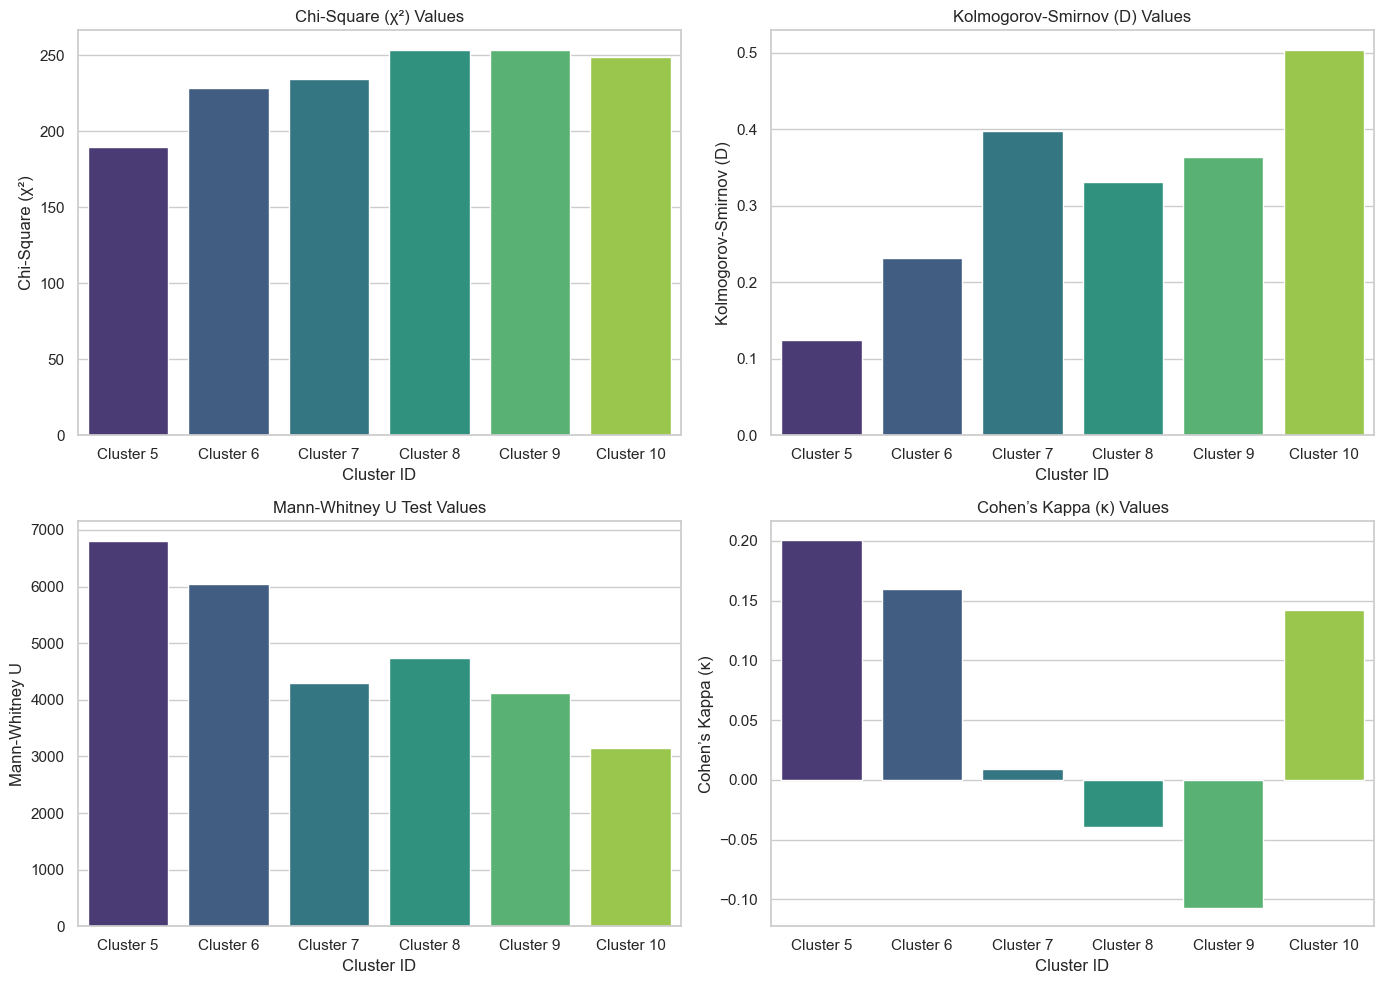

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data from your table
data = {
    "Cluster ID": ["Cluster 5", "Cluster 6", "Cluster 7", "Cluster 8", "Cluster 9", "Cluster 10"],
    "Chi-Square (χ²)": [189.544, 228.665, 234.596, 253.419, 253.735, 248.940],
    "p-value (Chi-Square)": [0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000],
    "Kolmogorov-Smirnov (D)": [0.124, 0.231, 0.397, 0.331, 0.364, 0.504],
    "p-value (Kolmogorov-Smirnov)": [0.31129, 0.00297, 0.00000, 0.00000, 0.00000, 0.00000],
    "Mann-Whitney U": [6811.000, 6043.000, 4301.000, 4737.000, 4113.500, 3152.500],
    "p-value (Mann-Whitney U)": [0.33786, 0.01679, 0.00000, 0.00000, 0.00000, 0.00000],
    "Cohen’s Kappa (κ)": [0.201, 0.160, 0.009, -0.039, -0.107, 0.142]
}

# Convert data into a DataFrame
df = pd.DataFrame(data)

# Set the style of seaborn
sns.set(style="whitegrid")

# Create subplots for the various metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Chi-Square Plot
sns.barplot(x="Cluster ID", y="Chi-Square (χ²)", data=df, ax=axes[0, 0], palette="viridis")
axes[0, 0].set_title("Chi-Square (χ²) Values")
axes[0, 0].set_ylabel("Chi-Square (χ²)")

# Kolmogorov-Smirnov (D) Plot
sns.barplot(x="Cluster ID", y="Kolmogorov-Smirnov (D)", data=df, ax=axes[0, 1], palette="viridis")
axes[0, 1].set_title("Kolmogorov-Smirnov (D) Values")
axes[0, 1].set_ylabel("Kolmogorov-Smirnov (D)")

# Mann-Whitney U Plot
sns.barplot(x="Cluster ID", y="Mann-Whitney U", data=df, ax=axes[1, 0], palette="viridis")
axes[1, 0].set_title("Mann-Whitney U Test Values")
axes[1, 0].set_ylabel("Mann-Whitney U")

# Cohen's Kappa Plot
sns.barplot(x="Cluster ID", y="Cohen’s Kappa (κ)", data=df, ax=axes[1, 1], palette="viridis")
axes[1, 1].set_title("Cohen’s Kappa (κ) Values")
axes[1, 1].set_ylabel("Cohen’s Kappa (κ)")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()
